In [1]:
from network import *
import numpy as np 
from scipy.sparse import csr_matrix
from scipy.stats import moment
import matplotlib.pyplot as plt

In [2]:
data = np.genfromtxt("connections.csv", delimiter=",")
N = int(np.max(data)) + 1
A = csr_matrix((np.ones(len(data)), (data[:, 0], data[:, 1])), shape = (N, N), dtype = np.int32)
A = A + A.T
A = 1*(A > 0)

In [3]:
#getting the degrees of the matrix
kmin = 15
degrees = get_degrees(A)

#getting the pdf of the nodes degrees
uniques, pdf = get_neighbours_pdf(degrees)

#getting the cumulative distribution function
cumpdf = ccdf(pdf)

#estimating the parameters to be used in the power law
gamma, c = estimate_power_law(degrees, kmin)
C = c*cumpdf[np.where(uniques == kmin)]
print("gamma = ", gamma)
print("Average degree = ", np.mean(degrees))
print("Statistical power = ", moment(degrees, moment = 2))
print("Third moment = ", moment(degrees, moment = 3))


gamma =  2.4505058418961614
Average degree =  12.287339971550498
Statistical power =  [394.46651113]
Third moment =  [41720.78892784]


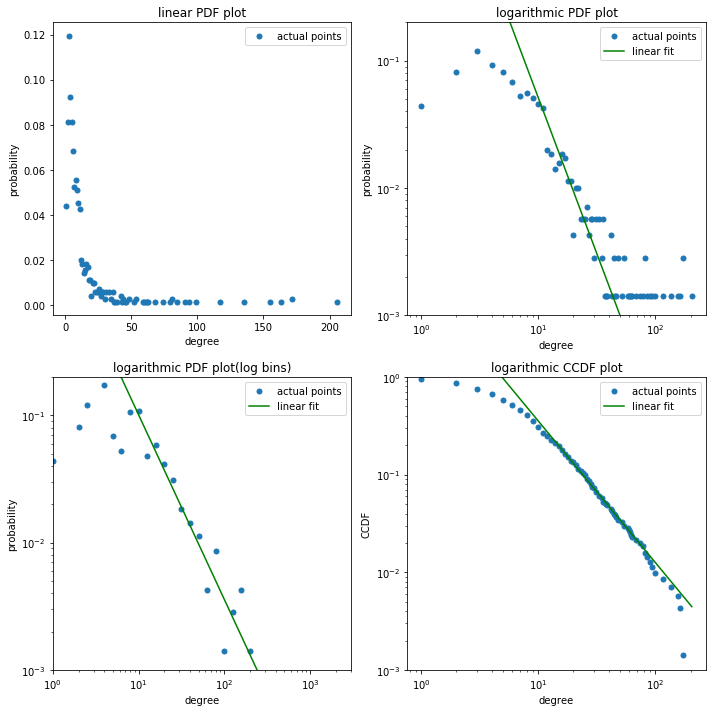

In [4]:
%matplotlib inline
fig, axs = plt.subplots(2, 2, figsize = (10, 10))

#plotting the pdf
axs[0, 0].set_title("linear PDF plot")
axs[0, 0].plot(uniques, pdf, marker='o', linestyle='None', ms = 5)
axs[0, 0].set(xlabel='degree', ylabel='probability')
axs[0, 0].legend(["actual points"])

#plotting the pdf and the linear fit
axs[0, 1].set_title("logarithmic PDF plot")
axs[0, 1].set_ylim(1e-5, 1)
axs[0, 1].loglog(uniques, pdf, marker='o', linestyle='None', ms = 5)
axs[0, 1].loglog(np.arange(1, np.max(uniques)), C * (np.arange(1, np.max(uniques)) ** -gamma), c="green")
axs[0, 1].set(xlabel='degree', ylabel='probability')
axs[0, 1].set_ylim(0.001, 0.2)
axs[0, 1].legend(["actual points", "linear fit"])

#plotting the linear binning pdf
axs[1, 0].set_title("logarithmic PDF plot(log bins)")
axs[1, 0].set_xlim(1, 3*10e2)
axs[1, 0].set_ylim(1e-4, 1)
x, y = log_binning_pdf(0.1, degrees)
axs[1, 0].loglog(x, y, marker='o', linestyle='None', ms = 5)
axs[1, 0].loglog(x, C / (gamma - 1) * x ** (1 - gamma) * (1 - (x[1] / x[0]) ** (1 - gamma)), c="green")
axs[1, 0].set(xlabel='degree', ylabel='probability')
axs[1, 0].set_ylim(0.001, 0.2)
axs[1, 0].legend(["actual points", "linear fit"])


#plotting the ccdf and the corresponding linear fit
axs[1, 1].set_title("logarithmic CCDF plot")
axs[1, 1].set_ylim((1e-5, 1))
axs[1, 1].loglog(uniques, ccdf(pdf), marker='o', linestyle='None', ms = 5)
axs[1, 1].loglog(np.arange(1, np.max(uniques)), C * np.arange(1, np.max(uniques))**(1-gamma)/(gamma-1), c="green")
axs[1, 1].set(xlabel='degree', ylabel='CCDF')
axs[1, 1].set_ylim(0.001, 1)
axs[1, 1].legend(["actual points", "linear fit"])

#used to prevent label overlapping
fig.tight_layout()

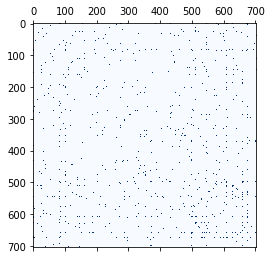

In [5]:
plt.matshow(A.toarray(), cmap="Blues")

In [6]:
characters_id = []
with open("nodes.csv", "r") as fp:
    for line in fp:
        name, name_ID = line.replace("\n", "").split(",")
        characters_id.append(name)

In [7]:
indexes = np.argsort(degrees, axis = 0)
for i in indexes[-1:-4:-1, 0]:
    print(characters_id[i])

Tyrion Lannister
Jaime Lannister
Arya Stark


In [8]:
print(N)
A = clean_network(A)
print(A.shape)

703
(703, 703)


max distance =  4.0
average distance =  2.6952904321325373


Text(0.5, 1.0, 'Number of characters that need n hops to reach another character')

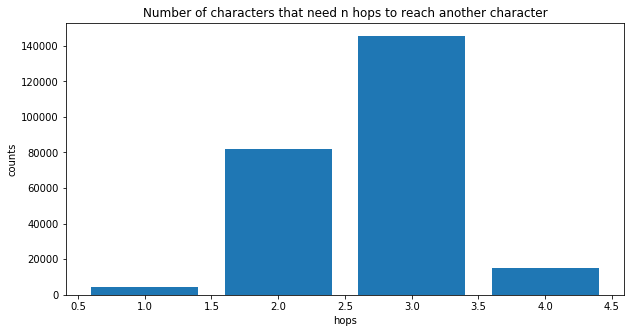

In [9]:
distances, counts = get_distance_distribution(A)
print("max distance = ", distances[-1])
print("average distance = ", np.sum(distances * counts)/np.sum(counts))
plt.figure(figsize=(10, 5))
plt.bar(distances, counts)
plt.xlabel("hops")
plt.ylabel("counts")
plt.title("Number of characters that need n hops to reach another character")

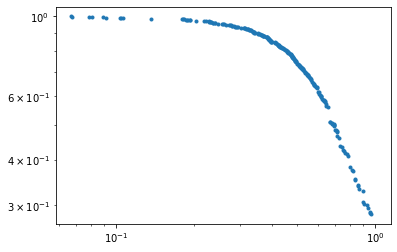

In [10]:
x, y = get_clustering_distribution(A)
plt.loglog(x, ccdf(y), marker=".", linestyle = "None")

In [11]:
print(np.sum(x*y))

0.6962753064672782


-0.22841945768210126


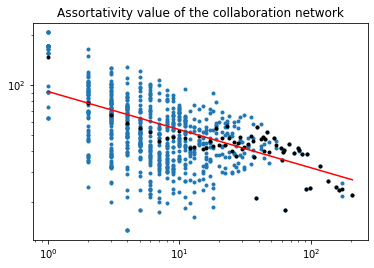

In [12]:
p, unique, knn, temp_knn = get_assortativity_value(A)
degrees = remove_zeros(get_degrees(A))

plt.title("Assortativity value of the collaboration network")
plt.loglog(degrees, temp_knn, marker=".", linestyle='None')
plt.loglog(unique, knn, marker = '.', linestyle='None', c='black')
plt.loglog(unique, np.exp(p[1] + np.log(unique)*p[0]), c = 'r')
print(p[0])
plt.show()

In [13]:
nodes = [[]]
i = 0
with open("connections_for_temp.csv", "r") as fp:
    for line in fp:
        if line == "end\n":
            i += 1
            nodes.append([])
        else:
            nodes[i].append([int(i) for i in line.replace("\n","").split(',')])            

In [14]:
import warnings
from scipy.sparse import (spdiags, SparseEfficiencyWarning, csc_matrix,
    csr_matrix, isspmatrix, dok_matrix, lil_matrix, bsr_matrix)
warnings.simplefilter('ignore',SparseEfficiencyWarning)

temporal_A = sp.sparse.csr_matrix((N,N))
a = get_temporal_distribution(temporal_A, nodes)

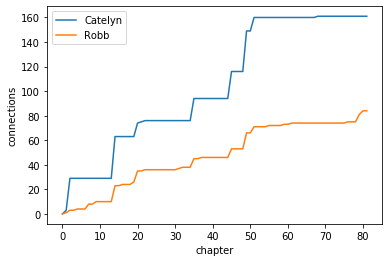

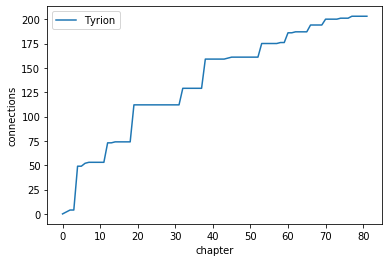

In [15]:
plt.plot(np.arange(82), a[:, characters_id.index("Catelyn Stark") ,0])
plt.plot(np.arange(82), a[:, characters_id.index("Robb Stark") ,0])
plt.xlabel("chapter")
plt.ylabel("connections")
plt.legend(["Catelyn", "Robb"])
plt.figure()
plt.plot(np.arange(82), a[:, characters_id.index("Tyrion Lannister") ,0])
plt.xlabel("chapter")
plt.ylabel("connections")
plt.legend(["Tyrion"])

0
0.014123802953198481


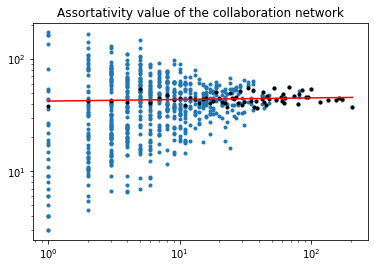

In [16]:
B = random_rewiring(A)
p, unique, knn, temp_knn = get_assortativity_value(B)
degrees = remove_zeros(get_degrees(B))

plt.title("Assortativity value of the collaboration network")
plt.loglog(degrees, temp_knn, marker=".", linestyle='None')
plt.loglog(unique, knn, marker = '.', linestyle='None', c='black')
plt.loglog(unique, np.exp(p[1] + np.log(unique)*p[0]), c = 'r')
print(p[0])
plt.show()

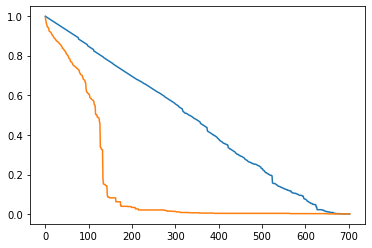

In [17]:
random_removal, attack_removal = check_robustness(A)
plt.plot(np.array(random_removal)/N)
plt.plot(np.array(attack_removal)/N)